# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [2]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 20

# Data preparation

In [3]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [4]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [5]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [6]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [7]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

## Handling IID data

In [1]:
def quantum_step_size(it, L, omega, N): return 1 / (8 * L)

In [8]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

In [9]:
#Transforming into torch.FloatTensor
X_merged = torch.tensor(X_scaled, dtype=torch.float64)
Y_merged = torch.tensor(Y_scaled.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
dim_notebook = X[0].shape[1]
for x in X:
    print("Number of points on this device:", len(x))

Number of points by devices:  2500
There is 20 devices.
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500


In [10]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.4808
ratio of state 1 on this device:  0.5092
ratio of state 1 on this device:  0.5064
ratio of state 1 on this device:  0.4744
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5192
ratio of state 1 on this device:  0.4844
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5236
ratio of state 1 on this device:  0.498
ratio of state 1 on this device:  0.4912
ratio of state 1 on this device:  0.4856
ratio of state 1 on this device:  0.4964
ratio of state 1 on this device:  0.5068
ratio of state 1 on this device:  0.5
ratio of state 1 on this device:  0.4924
ratio of state 1 on this device:  0.4936
ratio of state 1 on this device:  0.4928
ratio of state 1 on this device:  0.4916
ratio of state 1 on this device:  0.51


In [11]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [18]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                               ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-iid-obj_min")

   it    |   obj   
     100 | 5.4554e-01
     200 | 5.4341e-01
     300 | 5.4308e-01
     400 | 5.4301e-01
Gradient Descent: execution time=5.385 seconds
Final loss : 0.54298

CPU times: user 21.3 s, sys: 188 ms, total: 21.5 s
Wall time: 5.39 s


In [15]:
def ratio_failure(index: int, guess: int = 1):
    x = X[index]
    y = Y[index]
    w = obj_min_by_N_descent.model_params[-1]
    mul =  x.mv(w)
    inf_middle = 0
    failure = 0
    for i in range(len(mul)):
        if guess == 1:
            if torch.sigmoid(mul[i]) >= 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
        else:
            if torch.sigmoid(mul[i]) < 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
    print("Number of labels equal to " + str(guess) + ": ", inf_middle)
    print("Failures:", failure)
    print("Percent of labels wrongly predicted to be state " + str(guess) +" for worker 0: " + 
          str(failure/inf_middle * 100) + "%")
    
ratio_failure(1, 1)
ratio_failure(0, 1)

Number of labels equal to 1:  1249
Failures: 361
Percent of labels wrongly predicted to be state 1 for worker 0: 28.903122497998403%
Number of labels equal to 1:  1238
Failures: 386
Percent of labels wrongly predicted to be state 1 for worker 0: 31.179321486268176%


In [16]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               step_formula=quantum_step_size,
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-iid-descent")

100%|██████████| 5/5 [09:05<00:00, 109.11s/it]

CPU times: user 9min 19s, sys: 5.37 s, total: 9min 24s
Wall time: 9min 5s


In [16]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-0.0757, -0.0930,  0.0179, -0.1012,  0.7777,  0.0700,  0.0289, -0.0318,
         0.2951, -0.0717,  0.1087, -0.0680, -0.0437,  1.2050,  0.4734,  0.2868,
        -0.0317, -0.0234, -0.0364, -0.0805, -0.0422,  0.0391, -0.0391, -0.0311,
        -0.0257, -0.0140,  0.0392, -0.1598,  0.0661, -0.0112, -0.0886, -0.1380,
        -0.0351, -0.0164, -0.1758,  0.0088, -0.0144,  0.0464,  0.1085, -0.0140,
         0.0807,  0.0119,  0.0588, -0.2130,  0.0919, -0.0626,  0.0242, -0.0638,
         0.0818,  0.0275,  0.0809, -0.0189, -0.0077,  0.2859,  0.1533,  0.0303,
        -0.0958,  0.1337,  0.4036, -0.0093, -0.0195, -0.0748, -0.7768, -0.0754,
         0.0991, -0.0390], dtype=torch.float64)


### With averaging

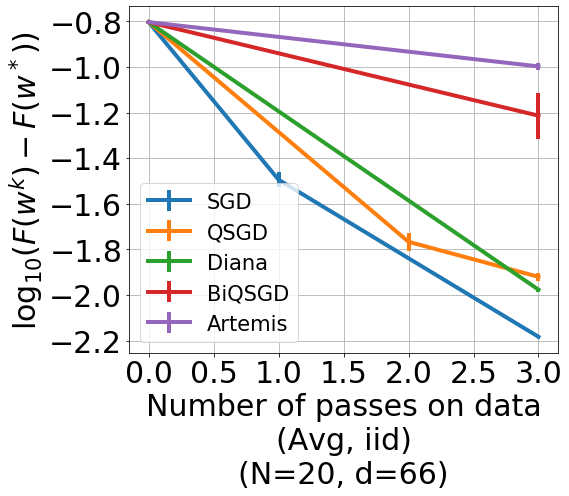

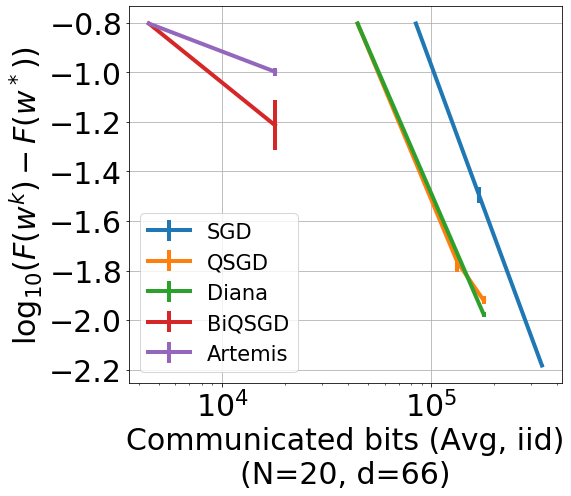

In [19]:
obj = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data\n(Avg, iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, iid)") 


### Without averaging

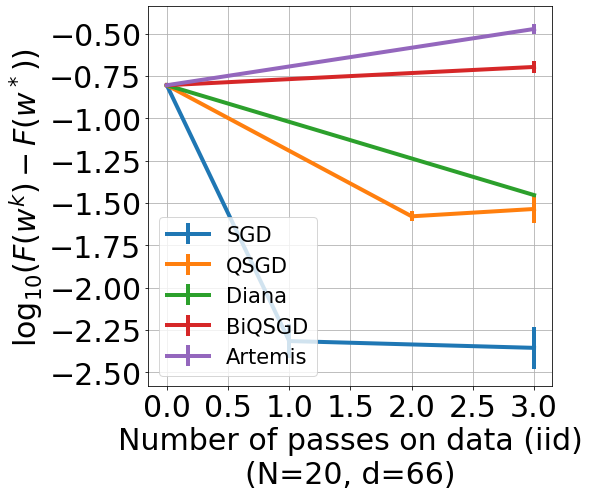

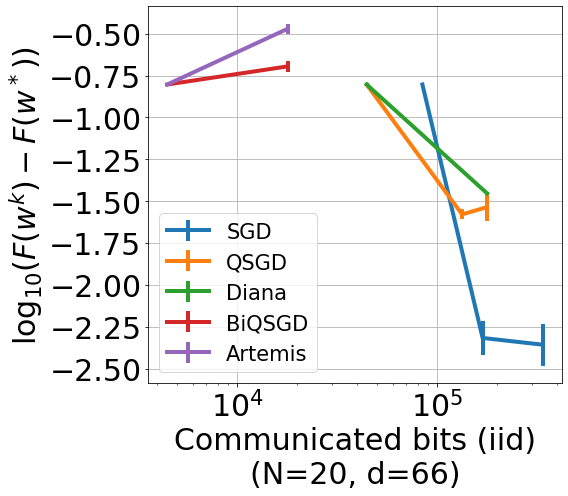

In [20]:
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_legend="Number of passes on data (iid)", all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (iid)", all_error=res.get_std(obj)) 

# Handling non-iid data

CPU times: user 1h 1min 19s, sys: 2min 38s, total: 1h 3min 58s
Wall time: 11min 52s


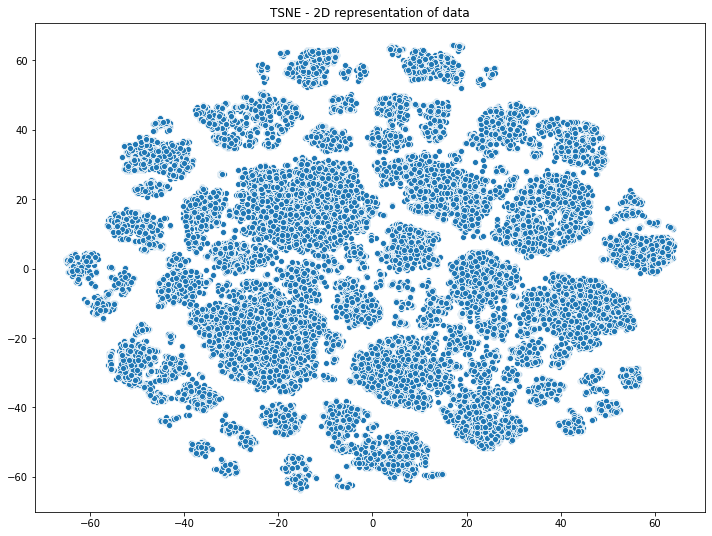

In [19]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tsne(data)
pickle_saver(embedded_data, filename + "-tsne")

There is 20 devices.
Number of points on device 0 : 3328
Number of points on device 1 : 1287
Number of points on device 2 : 1022
Number of points on device 3 : 2841
Number of points on device 4 : 1330
Number of points on device 5 : 7237
Number of points on device 6 : 3560
Number of points on device 7 : 731
Number of points on device 8 : 2167
Number of points on device 9 : 2881
Number of points on device 10 : 1123
Number of points on device 11 : 5230
Number of points on device 12 : 3438
Number of points on device 13 : 2571
Number of points on device 14 : 990
Number of points on device 15 : 1391
Number of points on device 16 : 1044
Number of points on device 17 : 1510
Number of points on device 18 : 2562
Number of points on device 19 : 3757
CPU times: user 48min 4s, sys: 3min 7s, total: 51min 11s
Wall time: 3min 25s


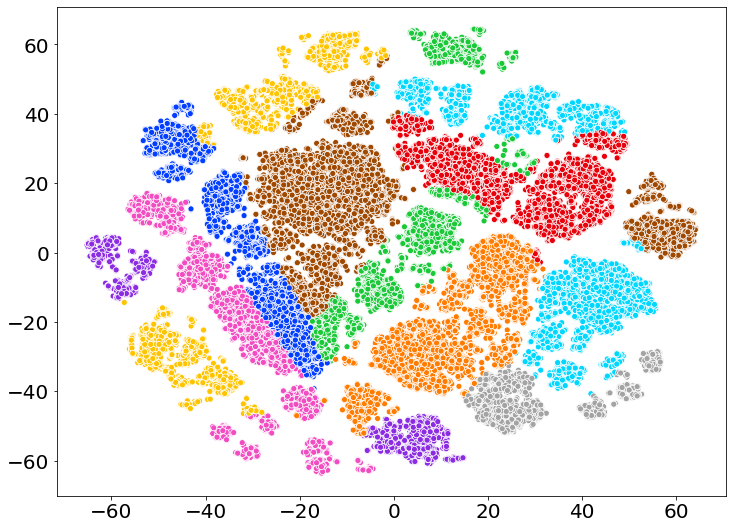

In [20]:
%%time
nb_cluster = nb_devices_for_the_run
embedded_data = pickle_loader(filename + "-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

CPU times: user 58min 13s, sys: 2min 30s, total: 1h 44s
Wall time: 10min 10s


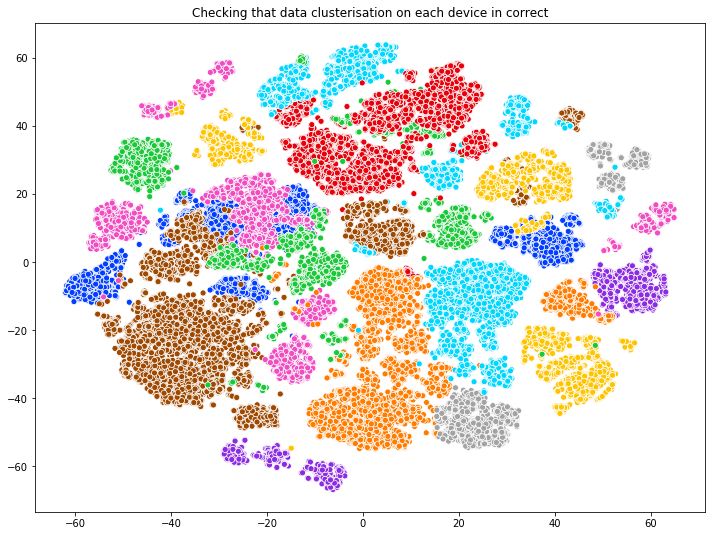

In [21]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [22]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.6126802884615384
ratio of state 1 on this device:  0.000777000777000777
ratio of state 1 on this device:  0.08904109589041095
ratio of state 1 on this device:  0.39528335093277017
ratio of state 1 on this device:  0.5511278195488721
ratio of state 1 on this device:  0.33232002210860856
ratio of state 1 on this device:  0.6528089887640449
ratio of state 1 on this device:  0.35567715458276333
ratio of state 1 on this device:  0.4240886017535764
ratio of state 1 on this device:  0.4807358556056925
ratio of state 1 on this device:  0.1585040071237756
ratio of state 1 on this device:  0.1739961759082218
ratio of state 1 on this device:  0.5663176265270506
ratio of state 1 on this device:  0.6499416569428238
ratio of state 1 on this device:  0.5131313131313131
ratio of state 1 on this device:  0.7433501078360891
ratio of state 1 on this device:  0.54693486590

In [23]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [24]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
   10000 | 5.4283e-01
   20000 | 5.4283e-01
   30000 | 5.4283e-01
   40000 | 5.4283e-01
Gradient Descent: execution time=595.753 seconds
Final loss : 0.54283

CPU times: user 2h 20min 57s, sys: 7min 58s, total: 2h 28min 56s
Wall time: 9min 55s


## Batch size $= 1$ (stochastic)

In [25]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               use_averaging=True, 
                                               step_formula=quantum_step_size,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
pickle_saver(res, filename + "-noniid-descent")

100%|██████████| 5/5 [2:05:34<00:00, 1506.95s/it]

CPU times: user 2h 48min 26s, sys: 3min 6s, total: 2h 51min 32s
Wall time: 2h 5min 34s


### With averaging

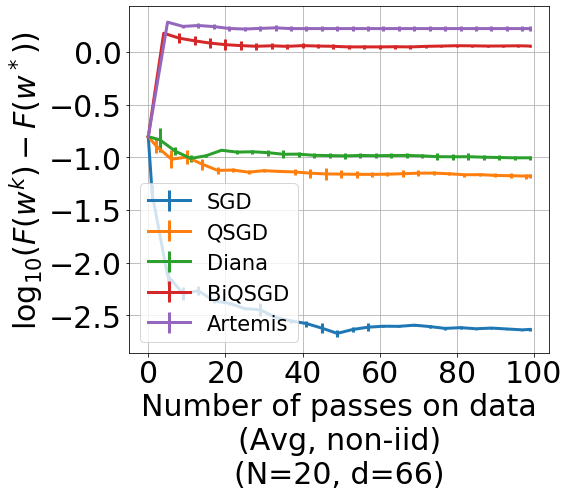

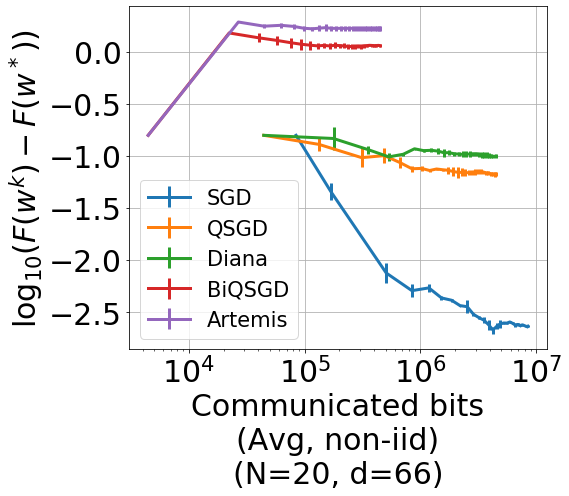

In [26]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

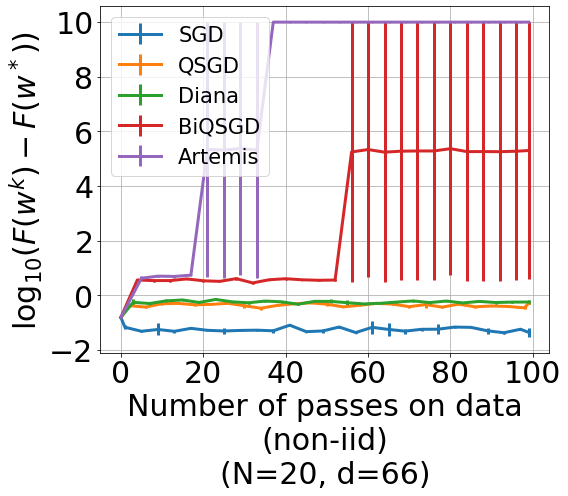

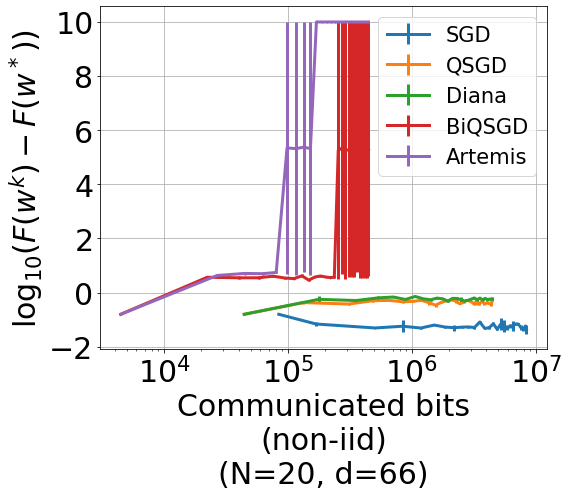

In [27]:
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

## Batch size $= 600$

In [28]:
%%time
batch_size = 600
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=True, batch_size=batch_size, 
                                               nb_epoch=1000, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-{1}".format(filename, batch_size))

100%|██████████| 5/5 [17:27<00:00, 209.58s/it]

CPU times: user 4h 6min 28s, sys: 15min 26s, total: 4h 21min 54s
Wall time: 17min 27s


### With averaging

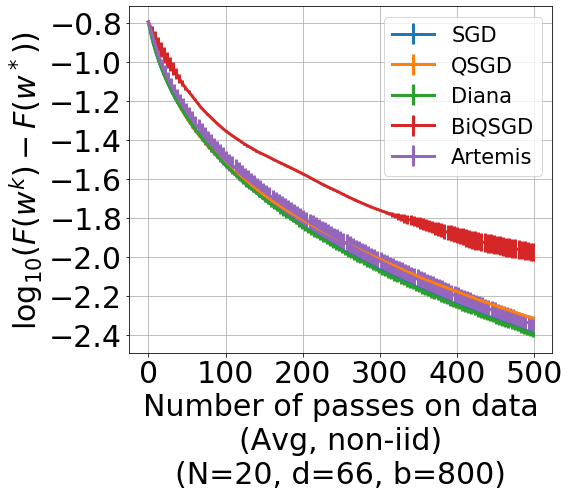

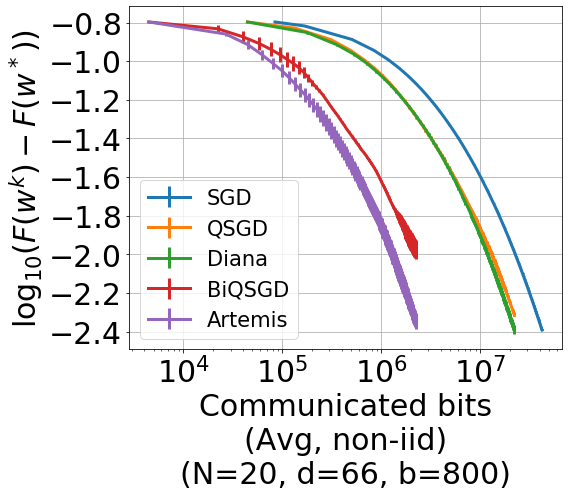

In [29]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

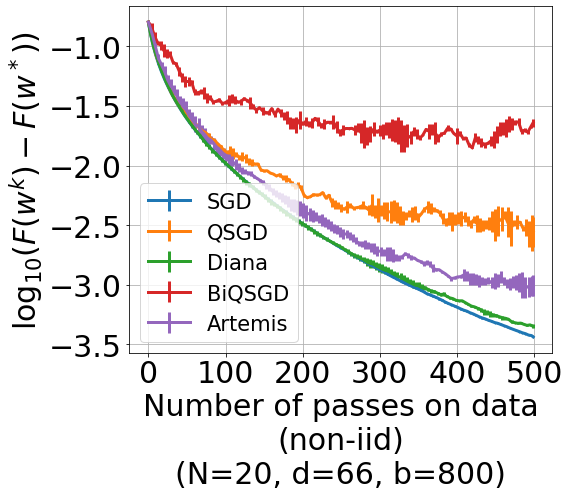

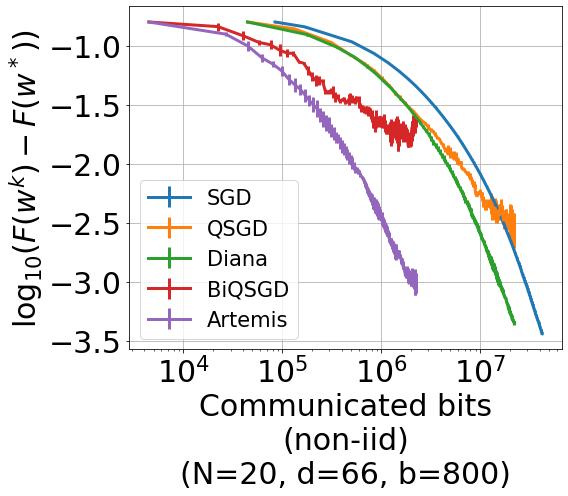

In [30]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 